<a href="https://colab.research.google.com/github/praneeth6124/U-net_for_brain_tumors/blob/main/U_net_on_medical_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## MRI image segmentation using U-Net

In [1]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR

# Defining the custom dataset

In [2]:
class TwoConvLayers(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, padding=1, bias=False),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(out_channels),
        )

    def forward(self, x):
        return self.model(x)

# Implementing the Encoder block

In [3]:
class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = TwoConvLayers(in_channels=in_channels, out_channels=out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        x = self.block(x)
        y = self.max_pool(x)
        return y, x

# implementing the decoder block

In [4]:
class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.transpose = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=2, stride=2)
        self.block = TwoConvLayers(in_channels=in_channels, out_channels=out_channels)

    def forward(self, x, y):
        x = self.transpose(x)
        u = torch.cat([x, y], dim=1)
        u = self.block(u)
        return u

# Implementing U-net model

In [5]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=1):
        super().__init__()
        self.enc_block1 = Encoder(in_channels=in_channels, out_channels=64)
        self.enc_block2 = Encoder(in_channels=64, out_channels=128)
        self.enc_block3 = Encoder(in_channels=128, out_channels=256)
        self.enc_block4 = Encoder(in_channels=256, out_channels=512)

        self.bottleneck = TwoConvLayers(in_channels=512, out_channels=1024)

        self.dec_block1 = Decoder(in_channels=1024, out_channels=512)
        self.dec_block2 = Decoder(in_channels=512, out_channels=256)
        self.dec_block3 = Decoder(in_channels=256, out_channels=128)
        self.dec_block4 = Decoder(in_channels=128, out_channels=64)

        self.out = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=1)

    def forward(self, x):
        x, y1 = self.enc_block1(x)
        x, y2 = self.enc_block2(x)
        x, y3 = self.enc_block3(x)
        x, y4 = self.enc_block4(x)

        x = self.bottleneck(x)

        x = self.dec_block1(x, y4)
        x = self.dec_block2(x, y3)
        x = self.dec_block3(x, y2)
        x = self.dec_block4(x, y1)

        return self.out(x)

# Defining the custom dataset class

In [6]:
from torch.utils.data import Dataset
from PIL import Image
import os

class MRIImageDataset(Dataset):
    def __init__(self, folder_path, valid_images, transform_img=None):
        self.folder_path = folder_path
        self.valid_images = valid_images
        self.transform_img = transform_img

        images_path = os.path.join(self.folder_path, 'images')
        masks_path  = os.path.join(self.folder_path, 'masks')  # correct folder

        self.images = [os.path.join(images_path, image) for image in self.valid_images]
        self.masks  = [os.path.join(masks_path, image)  for image in self.valid_images]

    def __getitem__(self, index):
        image_path = self.images[index]
        mask_path  = self.masks[index]

        image = Image.open(image_path).convert('L')  # grayscale
        mask  = Image.open(mask_path).convert('L')   # grayscale mask

        if self.transform_img:
            image = self.transform_img(image)
            mask  = self.transform_img(mask)

        return image, mask

    def __len__(self):
        return len(self.valid_images)


In [7]:
train_transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(10, shear=(-5,5)),
    transforms.ToTensor()])

test_transformations = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()])

In [8]:
import kagglehub
import os

path = kagglehub.dataset_download("nikhilroxtomar/brain-tumor-segmentation")
print("Downloaded to:", path)

print("Folders inside downloaded path:")
print(os.listdir(path))


100%|██████████| 312M/312M [00:01<00:00, 182MB/s]

Extracting files...


Downloaded to: /root/.cache/kagglehub/datasets/nikhilroxtomar/brain-tumor-segmentation/versions/1
Folders inside downloaded path:
['images', 'masks']


In [9]:
import os

data_path = "/root/.cache/kagglehub/datasets/nikhilroxtomar/brain-tumor-segmentation/versions/1"
print(os.listdir(data_path)[:10])


['images', 'masks']


In [10]:
import os

all_images = sorted(os.listdir(os.path.join(data_path, "images")))
# keep only image files
all_images = [f for f in all_images if f.endswith(".jpg") or f.endswith(".png")]
print("Total images:", len(all_images))


Total images: 3064


In [11]:
train_split = 0.85
split_idx = int(len(all_images) * train_split)

train_images = all_images[:split_idx]
val_images   = all_images[split_idx:]

print("Train images:", len(train_images))
print("Val images:", len(val_images))


Train images: 2604
Val images: 460


In [12]:
train_dataset = MRIImageDataset(data_path, train_images, transform_img=train_transformations)
val_dataset   = MRIImageDataset(data_path, val_images,   transform_img=test_transformations)

from torch.utils.data import DataLoader

batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


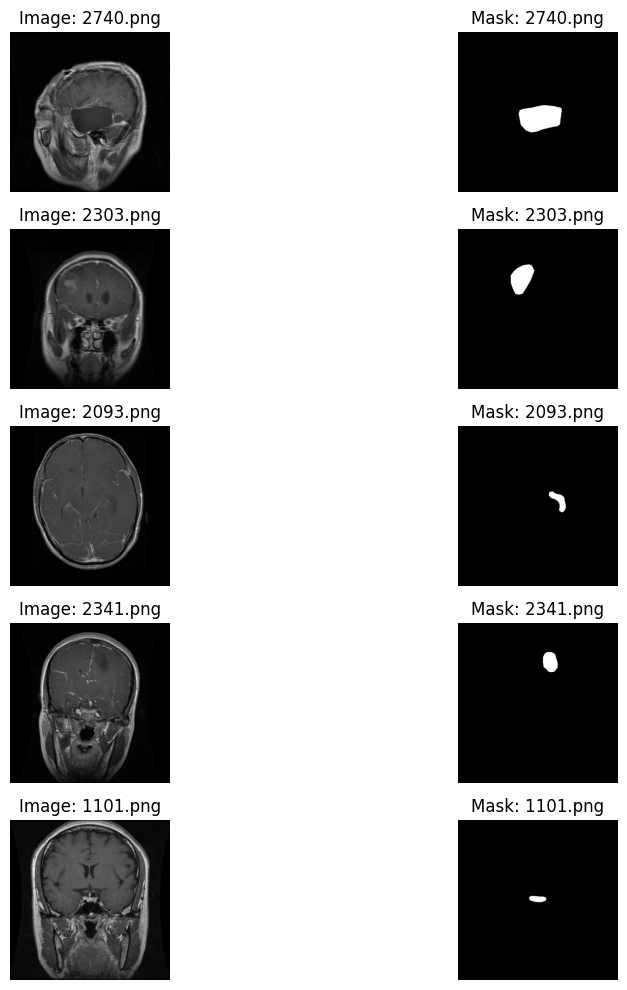

In [13]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# ✅ dataset path
data_path = "/root/.cache/kagglehub/datasets/nikhilroxtomar/brain-tumor-segmentation/versions/1"

image_dir = os.path.join(data_path, "images")
mask_dir = os.path.join(data_path, "masks")

image_files = os.listdir(image_dir)

# ✅ pick 5 random samples
samples = random.sample(image_files, 5)

plt.figure(figsize=(12, 10))

for i, img_name in enumerate(samples):
    img_path = os.path.join(image_dir, img_name)
    mask_path = os.path.join(mask_dir, img_name)  # mask has same name

    img = Image.open(img_path).convert("L")
    mask = Image.open(mask_path).convert("L")

    # MRI
    plt.subplot(5, 2, 2*i + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image: {img_name}")
    plt.axis("off")

    # Mask
    plt.subplot(5, 2, 2*i + 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask: {img_name}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [14]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # logits: (B, 1, H, W)
        # targets: (B, 1, H, W)

        probs = torch.sigmoid(logits)

        probs = probs.view(probs.size(0), -1)
        targets = targets.view(targets.size(0), -1)

        intersection = (probs * targets).sum(dim=1)
        union = probs.sum(dim=1) + targets.sum(dim=1)

        dice = (2 * intersection + self.smooth) / (union + self.smooth)

        return 1 - dice.mean()


In [15]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

in_channels = 1          # grayscale MRI
num_classes = 1          # binary mask

model = UNet(in_channels, num_classes).to(device)


In [16]:
model.to(device)


UNet(
  (enc_block1): Encoder(
    (block): TwoConvLayers(
      (model): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): ReLU(inplace=True)
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_block2): Encoder(
    (block): TwoConvLayers(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1,

In [34]:
criterion_1 = nn.BCEWithLogitsLoss()
criterion_2 = DiceLoss()   # your custom Dice loss
EPOCH = 12
BATCH_SIZE = 4
LR = 1e-4
THRESHOLD = 0.5
device = "cuda:0"
best_loss = float("inf")
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1)



In [26]:
# --------------------------
# EARLY STOPPING SETUP (before training loop)
# --------------------------
patience = 5               # how many epochs to wait for improvement
counter = 0                # counts epochs without improvement
best_loss = float('inf')   # initialize best validation loss


In [35]:
# --------------------------
# TRAINING LOOP
# --------------------------
for epoch in range(EPOCH):
    print(f"\nEpoch {epoch+1}/{EPOCH}")
    print("=" * 100)

    # --------------------------
    # TRAINING
    # --------------------------
    model.train()
    total_train_loss = 0.0

    for image, mask in train_loader:
        image = image.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        outputs = model(image)

        loss = criterion_1(outputs, mask) + criterion_2(outputs, mask)
        total_train_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_train_loss = total_train_loss / len(train_loader)
    scheduler.step()

    # --------------------------
    # VALIDATION
    # --------------------------
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for image, mask in val_loader:
            image = image.to(device)
            mask = mask.to(device)
            outputs = model(image)
            val_loss = criterion_1(outputs, mask) + criterion_2(outputs, mask)
            total_val_loss += val_loss.item()

    average_val_loss = total_val_loss / len(val_loader)

    # --------------------------
    # EARLY STOPPING & SAVE BEST MODEL
    # --------------------------
    if average_val_loss < best_loss:
        best_loss = average_val_loss
        counter = 0  # reset counter if improvement
        torch.save(model.state_dict(), "best_loss_unet.pt")
    else:
        counter += 1  # increase counter if no improvement
        if counter >= patience:
            print(f"No improvement in validation loss for {patience} epochs. Stopping training.")
            break

    # Print losses for this epoch
    print(f"Train Loss: {average_train_loss:.4f} | Val Loss: {average_val_loss:.4f}")




Epoch 1/12
Train Loss: 0.8944 | Val Loss: 0.6775

Epoch 2/12
Train Loss: 0.8919 | Val Loss: 0.6736

Epoch 3/12
Train Loss: 0.8875 | Val Loss: 0.6369

Epoch 4/12
Train Loss: 0.8825 | Val Loss: 0.6307

Epoch 5/12
Train Loss: 0.8797 | Val Loss: 0.5856

Epoch 6/12
Train Loss: 0.8825 | Val Loss: 0.6217

Epoch 7/12
Train Loss: 0.8782 | Val Loss: 0.6236

Epoch 8/12
Train Loss: 0.8718 | Val Loss: 0.6173

Epoch 9/12
Train Loss: 0.8789 | Val Loss: 0.5400

Epoch 10/12
Train Loss: 0.8738 | Val Loss: 0.6270

Epoch 11/12
Train Loss: 0.8682 | Val Loss: 0.5255

Epoch 12/12
Train Loss: 0.8757 | Val Loss: 0.5888


In [28]:
model.load_state_dict(torch.load("best_loss_unet.pt"))
model.eval()  # set to evaluation mode


UNet(
  (enc_block1): Encoder(
    (block): TwoConvLayers(
      (model): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): ReLU(inplace=True)
        (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (enc_block2): Encoder(
    (block): TwoConvLayers(
      (model): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): ReLU(inplace=True)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1,

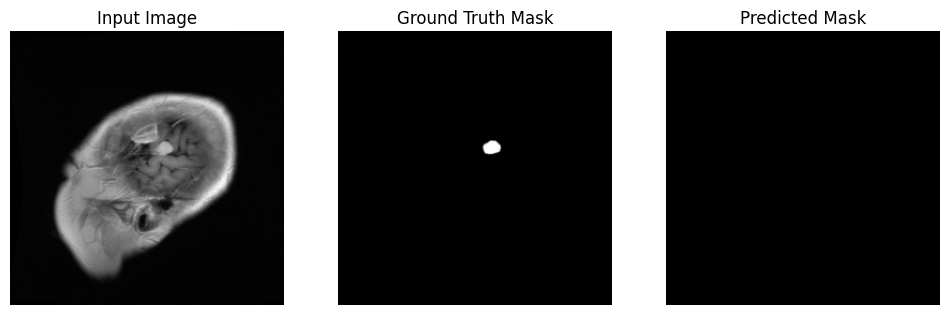

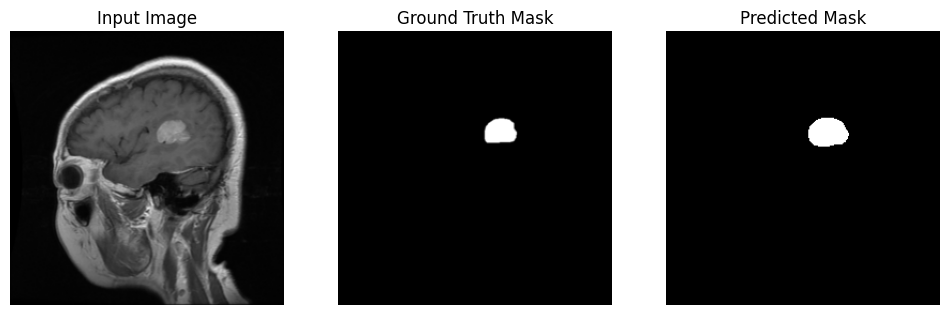

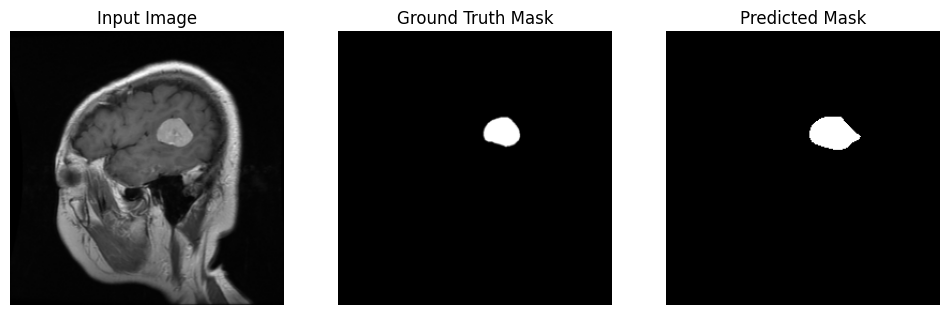

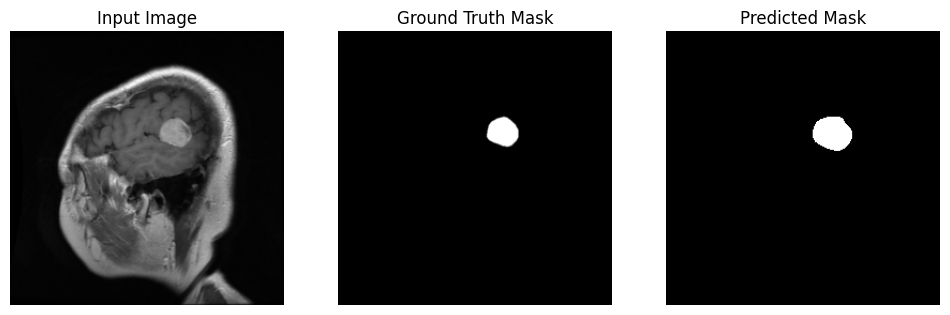

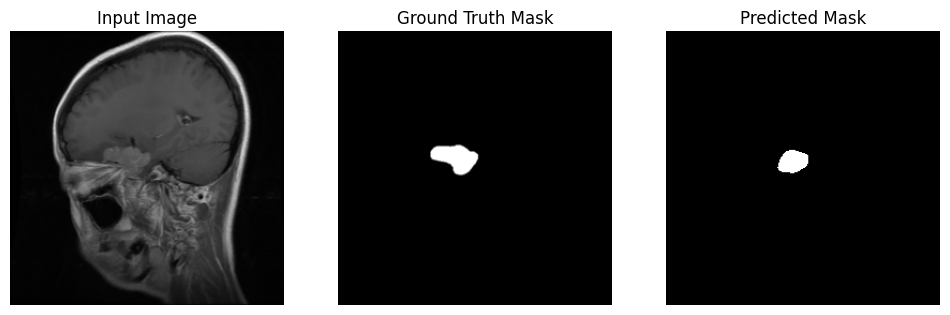

In [36]:
import matplotlib.pyplot as plt
import torch

def visualize_predictions_from_loader(model, val_loader, device, threshold=0.5, num_samples=5):
    """
    Visualize predictions from a validation DataLoader.

    model: trained UNet
    val_loader: validation DataLoader
    device: 'cuda' or 'cpu'
    threshold: sigmoid threshold to binarize predicted mask
    num_samples: how many images to visualize
    """
    model.eval()
    samples_shown = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            preds = torch.sigmoid(model(images))  # [B, 1, H, W]
            preds = (preds > threshold).float()

            batch_size = images.size(0)
            for i in range(batch_size):
                if samples_shown >= num_samples:
                    return  # stop after required samples

                img = images[i].cpu().squeeze(0)   # [H, W]
                mask = masks[i].cpu().squeeze(0)   # [H, W]
                pred_mask = preds[i].cpu().squeeze(0)  # [H, W]

                plt.figure(figsize=(12, 4))
                plt.subplot(1,3,1)
                plt.imshow(img, cmap='gray')
                plt.title("Input Image")
                plt.axis('off')

                plt.subplot(1,3,2)
                plt.imshow(mask, cmap='gray')
                plt.title("Ground Truth Mask")
                plt.axis('off')

                plt.subplot(1,3,3)
                plt.imshow(pred_mask, cmap='gray')
                plt.title("Predicted Mask")
                plt.axis('off')

                plt.show()

                samples_shown += 1

# Usage:
visualize_predictions_from_loader(model, val_loader, device, threshold=0.5, num_samples=5)


In [37]:
from sklearn.metrics import f1_score

model.eval()
dice_scores = []

with torch.no_grad():
    for images, masks in val_loader:
        images = images.to(device)
        masks = masks.to(device)
        preds = (torch.sigmoid(model(images)) > 0.5).float()

        for i in range(images.size(0)):
            y_true = (masks[i].cpu().numpy() > 0.5).astype(int).flatten()
            y_pred = preds[i].cpu().numpy().astype(int).flatten()
            dice = f1_score(y_true, y_pred)
            dice_scores.append(dice)

print(f"Average Dice Score: {sum(dice_scores)/len(dice_scores):.4f}")


Average Dice Score: 0.5185
